# Experiment 3: Using more examples from additional datasets
The motivation for this experiment is to see what effect more or less training samples will have on the f1 score of the BERT model. \
In my visualistion of the PLOD-CW dataset, I observed that a large amount of the tags in the dataset are B-O tags, it is worth experimenting with potentially making the dataset more balanced before fine tuning a model

In [ ]:
%pip install datasets
%pip install transformers
%pip install spacy
%pip install spacy-transformers
%pip install transformers[torch]
%pip install seqeval

In [ ]:
import torch
import torchtext

SEED = 1234
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

PyTorch Version:  2.2.1+cu121
torchtext Version:  0.17.1+cpu
Using GPU.


In [1]:
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")
additional_dataset = load_dataset("surrey-nlp/PLOD-filtered")

c:\Users\liamd\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = dataset["train"]
valid = dataset["validation"]
test = dataset["test"]


train_tokens = train["tokens"]
train_labels = train["ner_tags"]
valid_tokens = valid["tokens"]
valid_labels = valid["ner_tags"]
test_tokens = test["tokens"]
test_labels = test["ner_tags"]



In [3]:
additional_train = additional_dataset["train"]
additional_valid = additional_dataset["validation"]
additional_test = additional_dataset["test"]

additional_train_tokens = additional_train["tokens"]
additional_train_labels = additional_train["ner_tags"]
additional_valid_tokens = additional_valid["tokens"]
additional_valid_labels = additional_valid["ner_tags"]
additional_test_tokens = additional_test["tokens"]
additional_test_labels = additional_test["ner_tags"]

In [4]:
len(train_tokens), len(valid_tokens), len(test_tokens), len(additional_train_tokens), len(additional_valid_tokens), len(additional_test_tokens)

(1072, 126, 153, 112652, 24140, 24140)

In [ ]:
def token_count(tokens):
	count = 0
	for token in tokens:
		for i in token:
			count+=1
	return count

In [ ]:
train_token_count = token_count(train_tokens)
train_token_count

40000

## We can see that the PLOD-Filtered set contains many more samples than the standard cw version we have used up this point
### Motivation for this experiment
The motivation for this experiment is addressing the imbalanced nature of the PLOD-CW Dataset. \
As shown in my **visualisation.ipynb** notebook, the spread of the different 'NER' tags in the dataset (train split) is extremely imbalanced

![image.png](attachment:image.png)

![image.png](attachment:image.png)

## PLOD-CW dataset distribution
In the above graph, we can see that the majority of our dataset contains tokens that come under the 'B-O' tag. \
For this reason, it is entirely possible that any model that is fine tuned using this dataset could become 'biased' towards B-O tags purely because that is the dominant tag in the dataset.

## Looking at the PLOD-CW Test set
As stated above, it is likely that by having an imbalanced dataset (tag frequency), the model can become biased. The above graph shows the NER tag split across the train set, but another thing to consider is the tag split across the test set. Since we use the test set to assess our models accuracy, its also a good idea to analyse the distribution of the test set and balance it out if necessary

{'B-O': 4292, 'B-AC': 270, 'B-LF': 150, 'I-LF': 288}
Total tags:  5000


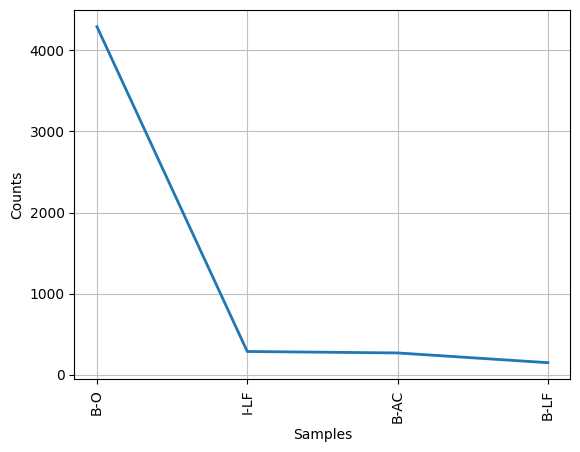

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
from nltk import FreqDist

#Analyse the NER tag distribution across PLOD-CW test split
#iterate over NER tags in training set
ner_tags = {'B-O': 0, 'B-AC': 0, 'B-LF': 0, 'I-LF':0}
for example in test:
  for tag in example["ner_tags"]:
    ner_tags[tag] += 1


print(ner_tags)
#calculate total tags from dict
total = 0
for i,v in ner_tags.items():
  total += v

print("Total tags: ", total)

# Create a FreqDist object for ner_tags
ner_tags_freq = FreqDist(ner_tags)

# Plot the distribution
ner_tags_freq.plot()





#  PLOD-CW Test set NER tag split
The NER tag split across the test set is similar to that of the train set. \
This is not an inherently bad thing as B-O tags are naturally more likely to occur than the other tags. \
Despite this, it is worth trying to experiment with a more balanced dataset.

# Approach for balancing the dataset
My approach for 'balancing' the dataset will be to go through PLOD-Filtered (large dataset) and find entries that contain majority non B-O tags, check if they are already in PLOD-CW, and if not then combine them

In [5]:
#Analysis of
import copy
#copy the dataset
combined_dataset = copy.deepcopy(dataset)

In [6]:
combined_dataset
combined_train = combined_dataset["train"]
combined_valid = combined_dataset["validation"]
combined_test = combined_dataset["test"]
combined_train_tokens = combined_train["tokens"]
combined_train_labels = combined_train["ner_tags"]



In [7]:
# Iterate over additional_tokens and additional_labels
def form_dataset(initial_tokens, initial_labels, additional_tokens, additional_labels, count):
	tag_mapper = {0: 'B-O', 1: 'B-AC', 3: 'B-LF', 4: 'I-LF'}
	added = 0
	for tokens, labels in zip(additional_tokens, additional_labels):
			# Count the number of non B-O tags
			if added>count:
					break
			converted_labels = [tag_mapper[label] for label in labels]
			non_bo_count = sum(label != 'B-O' for label in converted_labels)

			# Check if the majority of tags are non B-O
			if non_bo_count > len(labels) / 2:
					# Check if the entry is not already in combined_train
					if tokens not in combined_train['tokens']:
							# Add the entry to combined_train
							initial_tokens.append(tokens)
							initial_labels.append(converted_labels)
							added +=1
	return initial_tokens, initial_labels



In [ ]:
len(combined_train_tokens), len(combined_train_labels)
combined_train_tokens, combined_train_labels = form_dataset(combined_train_tokens, combined_train_labels, additional_train_tokens, additional_train_labels, 2000)

In [ ]:
len(combined_train_labels), len(combined_train_tokens)

In [8]:
balanced_tokens, balanced_labels = form_dataset([], [], additional_train_tokens, additional_train_labels, 1200)

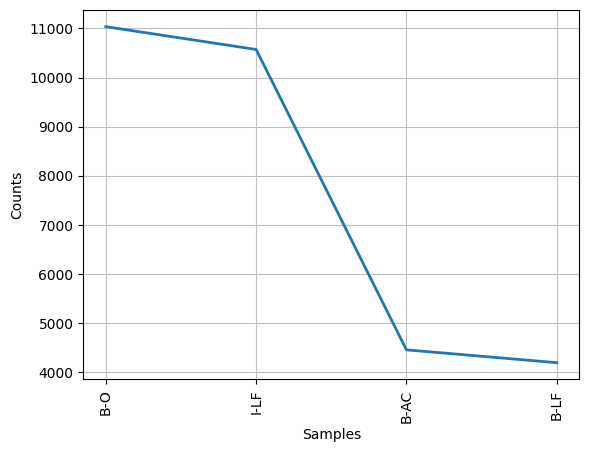

<Axes: xlabel='Samples', ylabel='Counts'>

In [10]:
from nltk import FreqDist

#Analyse the NER tag distribution across PLOD-CW test split
#iterate over NER tags in training set
ner_tags = {'B-O': 0, 'B-AC': 0, 'B-LF': 0, 'I-LF':0}
tag_mapper = {0: 'B-O', 1: 'B-AC', 3: 'B-LF', 4: 'I-LF'}

for i, example in enumerate(balanced_labels):
	for tag in example:
		ner_tags[tag] += 1



# Create a FreqDist object for ner_tags
ner_tags_freq = FreqDist(ner_tags)

# Plot the distribution
ner_tags_freq.plot()



# What I've done
I have formed a training set from PLOD-Filtered (larger dataset) that has a slightly different token distribution to that of the standard training set. \
I am now going to fine tune a BERT Model with this training set, then evaluate it against the regular PLOD-CW test set and look at the F1 scores of the different NER tags

In [11]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}
inverse_label_map = {v: k for k, v in label_encoding.items()}


# Defining utility functions

In [ ]:
!pip install seqeval

In [12]:
def conv_label_indexes(training, valid, test ):
	label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

	label_list = []
	for sample in training:
		label_list.append([label_encoding[tag] for tag in sample])

	val_label_list = []
	for sample in valid:
		val_label_list.append([label_encoding[tag] for tag in sample])

	test_label_list = []
	for sample in test:
		test_label_list.append([label_encoding[tag] for tag in sample])
	return label_list, val_label_list, test_label_list


def tokenize_and_align_labels(ngrams, list_name):
    tokenized_inputs = tokenizer(ngrams, truncation=True, is_split_into_words=True) ## For some models, you may need to set max_length to approximately 500.

    labels = []
    for i, label in enumerate(list_name):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


# BERT's tokenizer returns the dataset in the form of a dictionary of lists (sentences).
# we have to convert it into a list of dictionaries for training.
def turn_dict_to_list_of_dict(d):
    new_list = []

    for labels, inputs in zip(d["labels"], d["input_ids"]):
        entry = {"input_ids": inputs, "labels": labels}
        new_list.append(entry)

    return new_list

import numpy as np

metric = load_metric("seqeval")
def compute_metrics(p, label_list):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


def calculate_results(trainer, dataset, labels_list):

	predictions, labels, _ = trainer.predict(dataset)
	predictions = np.argmax(predictions, axis=2)

	# Remove the predictions for the [CLS] and [SEP] tokens
	true_predictions = [
			[labels_list[p] for (p, l) in zip(prediction, label) if l != -100]
			for prediction, label in zip(predictions, labels)
	]
	true_labels = [
			[labels_list[l] for (p, l) in zip(prediction, label) if l != -100]
			for prediction, label in zip(predictions, labels)
	]

	# Compute multiple metrics on the test restuls
	results = metric.compute(predictions=true_predictions, references=true_labels)
	return results


C:\Users\liamd\AppData\Local\Temp\ipykernel_2164\1491982232.py:59: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
c:\Users\liamd\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


# Loading BERT model

In [13]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=4)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
balanced_labels_list, validation_labels_list , test_labels_list = conv_label_indexes(balanced_labels, valid_labels, test_labels)
tokenized_train_dataset = tokenize_and_align_labels(balanced_tokens, balanced_labels_list)
tokenized_validation_dataset = tokenize_and_align_labels(valid_tokens, validation_labels_list)
tokenized_test_dataset = tokenize_and_align_labels(test_tokens, test_labels_list)
tokenized_train_dataset = turn_dict_to_list_of_dict(tokenized_train_dataset)
tokenized_validation_dataset = turn_dict_to_list_of_dict(tokenized_validation_dataset)
tokenized_test_dataset = turn_dict_to_list_of_dict(tokenized_test_dataset)

In [15]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Define trainer


In [16]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

def wrapper_compute_metrics(p):
  return compute_metrics(p, tokenized_train_dataset)

# Training arguments (feel free to play arround with these values)
model_name = "bert-base-uncased"
epochs = 6
batch_size = 4
learning_rate = 2e-5

args = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=wrapper_compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

c:\Users\liamd\AppData\Local\Programs\Python\Python312\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()



In [ ]:
results = calculate_results(trainer, tokenized_test_dataset, test_labels_list)
results

# Compare vs training with the standard PLOD-CW Dataset

In [ ]:
train_labels_list, validation_labels_list , test_labels_list = conv_label_indexes(train_labels, valid_labels, test_labels)
tokenized_train_dataset = tokenize_and_align_labels(train_tokens, train_labels)
tokenized_validation_dataset = tokenize_and_align_labels(valid_tokens, validation_labels_list)
tokenized_test_dataset = tokenize_and_align_labels(test_tokens, test_labels_list)
tokenized_train_dataset = turn_dict_to_list_of_dict(tokenized_train_dataset)
tokenized_validation_dataset = turn_dict_to_list_of_dict(tokenized_validation_dataset)
tokenized_test_dataset = turn_dict_to_list_of_dict(tokenized_test_dataset)

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

def wrapper_compute_metrics(p):
  return compute_metrics(p, tokenized_train_dataset)


# Training arguments (feel free to play arround with these values)
model_name = "bert-base-uncased"
epochs = 6
batch_size = 4
learning_rate = 2e-5

args = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=wrapper_compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
trainer.train()
results = calculate_results(trainer, tokenized_test_dataset, test_labels_list)
results
